<a href="https://colab.research.google.com/github/alexeiveselov92/Yandex-Data-Analysis/blob/master/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D1%82%D0%B8%D0%BA%D0%B0%20%D0%B2%20%D0%AF%D0%BD%D0%B4%D0%B5%D0%BA%D1%81.%D0%90%D1%84%D0%B8%D1%88%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Описание проекта
Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.

В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Изучим:
* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент
* когда клиент окупается.

## Загрузим данные и подготовим их к анализу

#### Загрузка библиотек

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import copy
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Загрузка датасетов

In [0]:
visits = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/visits_log.csv')
orders = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/orders_log.csv')
costs = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/costs.csv')

In [0]:
#напишем функцию перевода столбцов к нижнему регистру и замены пробелов на "_" 
def replace_columns_names(data):
    list_of_columns = []
    for column in data.columns:
        column = column.lower()
        column = column.replace(' ', '_')
        list_of_columns.append(column)
    data.columns = list_of_columns
    return data

#### Visits

In [17]:
#изменим навзания столбцов
visits = replace_columns_names(visits)
    
#переведем столбцы с датой и временем к соответстующим типам
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%d.%m.%Y %H:%M:%S')
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%d.%m.%Y %H:%M:$S')

#проверим перевелись ли к нужным типам столбцы
visits.info()
visits.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   uid        358532 non-null  uint64        
 1   device     358532 non-null  object        
 2   end_ts     358532 non-null  datetime64[ns]
 3   source_id  358532 non-null  int64         
 4   start_ts   358532 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


,uid,device,end_ts,source_id,start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


#### Orders

In [18]:
#изменим навзания столбцов
orders = replace_columns_names(orders)

#переведем столбцы с датой и временем к соответстующим типам
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y-%m-%d %H:%M:%S')

#проверим перевелись ли к нужным типам столбцы
orders.info()
orders.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


#### Costs

In [19]:
#изменим навзания столбцов
costs = replace_columns_names(costs)

#переведем столбцы с датой и временем к соответстующим типам
costs['dt'] = pd.to_datetime(costs['dt'])

#проверим перевелись ли к нужным типам столбцы
costs.info()
costs.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


## Построим отчёты и посчитаем метрики

### Продукт

 #### Сколько людей пользуются в день, неделю, месяц?

In [21]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['start_ts_day'] = visits['start_ts'].dt.date
visits['start_ts_week'] = pd.DatetimeIndex(visits['start_ts']).week
visits['start_ts_month'] = pd.DatetimeIndex(visits['start_ts']).month
visits['start_ts_year'] = pd.DatetimeIndex(visits['start_ts']).year

dau = visits.groupby(['start_ts_day']).agg({'uid':'nunique'}).mean()
wau = visits.groupby(['start_ts_year', 'start_ts_week']).agg({'uid':'nunique'}).mean()
mau = visits.groupby(['start_ts_year', 'start_ts_month']).agg({'uid':'nunique'}).mean()
print('В день сервисом в среднем пользуются {} людей'.format(int(dau)))
print('В неделю сервисом в среднем пользуются {} людей'.format(int(wau)))
print('В месяц сервисом в среднем пользуются {} людей'.format(int(mau)))

sticky_wau = dau / wau
sticky_mau = dau / mau
print('Недельная вовлеченность аудитории: {:.2%}'.format(sticky_wau[0]))
print('Месячная вовлеченность аудитории: {:.2%}'.format(sticky_mau[0]))
print('''
Видим, что вовлеченность аудитории не высокая, очевидно, что сервисом пользуются редко.''')

В день сервисом в среднем пользуются 907 людей
В неделю сервисом в среднем пользуются 5716 людей
В месяц сервисом в среднем пользуются 23228 людей
Недельная вовлеченность аудитории: 15.88%
Месячная вовлеченность аудитории: 3.91%

Видим, что вовлеченность аудитории не высокая, очевидно, что сервисом пользуются редко.


 #### Сколько сессий в день?

In [22]:
day_visits = visits.groupby(['start_ts_day']).agg({'uid':'count'})
print('В день в среднем проходит {} сессий'.format(int(day_visits.mean()[0])))

В день в среднем проходит 984 сессий


 #### Сколько длится одна сессия?

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


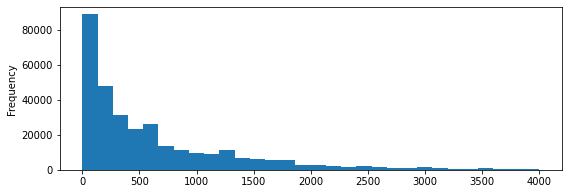

count    322738.000000
mean        716.555658
std        1047.837283
min          60.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: duration, dtype: float64
Одна сессия длится в среднем 60 секунд 
В нашем случае распределение длительности далеко от нормального, поэтому мы используем моду (значение, встречающееся чаще всего)


In [61]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
mean_session = visits[visits['duration'] != '0 seconds']['duration'].mode()
durations_of_visits = visits[visits['duration'] != 0]['duration']
durations_of_visits.plot(kind = 'hist', bins = 30, figsize = (9,3), range = (0, 4000))
plt.show()
print(durations_of_visits.describe())
print('''Одна сессия длится в среднем {} секунд 
В нашем случае распределение длительности далеко от нормального, ''' 
'поэтому мы используем моду (значение, встречающееся чаще всего)'.format(mean_session[0]))

#### Как часто люди возвращаются?

In [24]:
sessions_per_user = len(visits) / len(visits['uid'].unique())
print('В среднем на одного пользователя приходится {:.2f} сессий \n'
      'Данный показатель подтверждает то, что сервисом пользуются редко.\n'
      '\n'
      'Построим Retention Rate, чтобы посмотреть как часто возвращаются пользователи в рамках когорт'.format(sessions_per_user))

В среднем на одного пользователя приходится 1.57 сессий 
Данный показатель подтверждает то, что сервисом пользуются редко.

Построим Retention Rate, чтобы посмотреть как часто возвращаются пользователи в рамках когорт


In [0]:
#найдем первую активность пользователей
first_activity = visits.groupby('uid').agg({'start_ts':'min'})
first_activity.columns = ['first_activity']
visits = visits.join(first_activity, on='uid')

In [26]:
#создадим новый датафрейм чтобы не видеть не нужные столбцы
visits_rr = visits[['uid', 'first_activity', 'start_ts']]
visits_rr['first_activity_month'] = visits_rr['first_activity'].astype('datetime64[M]')
visits_rr['start_ts_month'] = visits_rr['start_ts'].astype('datetime64[M]')
visits_rr['lifetime'] = ((visits_rr['start_ts_month'] - visits_rr['first_activity_month']) / np.timedelta64(1, 'M')).round().astype('int')
visits_rr.head(5)
cohorts_visits = visits_rr.groupby(['first_activity_month', 'lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts_visits[cohorts_visits['lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count.columns = ['first_activity_month', 'cohort_users']
initial_users_count = initial_users_count.set_index('first_activity_month')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [0]:
cohorts_visits = cohorts_visits.join(initial_users_count, on = 'first_activity_month')

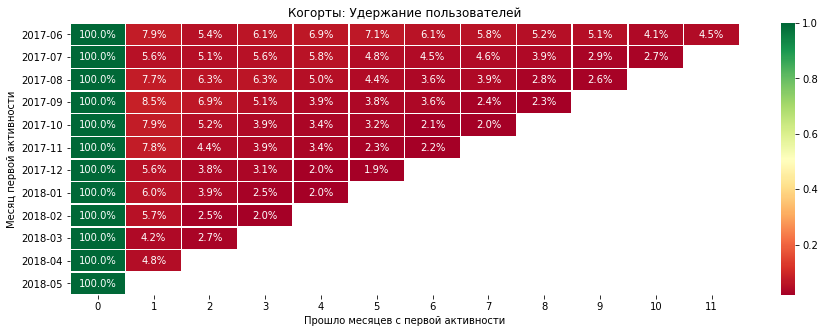

Как мы видим, возвращаются пользователи редко.


In [28]:
cohorts_visits['retention'] = cohorts_visits['uid'] / cohorts_visits['cohort_users']
retention_pivot = cohorts_visits.pivot_table(index='first_activity_month',
                                      columns='lifetime',
                                      values='retention',
                                      aggfunc='sum')
retention_pivot = retention_pivot.reset_index()
retention_pivot['first_activity_month'] = retention_pivot['first_activity_month'].dt.strftime('%Y-%m')
retention_pivot = retention_pivot.set_index('first_activity_month')
retention_pivot

plt.figure(figsize=(15, 5))
plt.title('Когорты: Удержание пользователей')
sns.heatmap(retention_pivot, annot=True, fmt=".1%", linewidths=.5, cmap = 'RdYlGn')
plt.ylabel('Месяц первой активности')
plt.xlabel('Прошло месяцев с первой активности')
plt.show()
print('Как мы видим, возвращаются пользователи редко.')

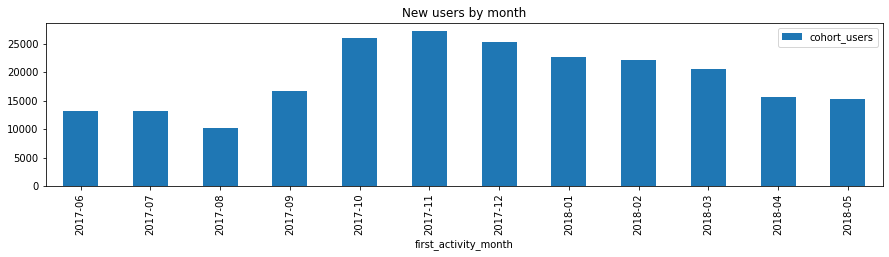

In [29]:
#посмотрим количества новых пользователей по месяцам
cohorts_visits['first_activity_month'] = cohorts_visits['first_activity_month'].dt.strftime('%Y-%m')
cohorts_visits = cohorts_visits.set_index('first_activity_month')
new_users_by_month = cohorts_visits[cohorts_visits['lifetime'] == 0][['cohort_users']]
new_users_by_month.plot(kind = 'bar', figsize = (15,3), title = 'New users by month')
plt.show()

<font color='blue'> Отлично, retention получен верно. </font>

### Продажи
#### Когда люди начинают покупать?

In [0]:
#найдём время и дату первой сессии 
first_sessions = visits.groupby(['uid']).agg({'start_ts':'min', 'source_id':'first'})
first_sessions.columns = ['first_activity', 'first_source']

#найдем время первой покупки
first_orders = orders.groupby(['uid']).agg({'buy_ts':'min'})
first_orders.columns = ['first_buy_ts']

#добавим дату и время первой сессии в информацию по первым заказам
first_orders = first_orders.join(first_sessions,on='uid')

Медиана времени с первой сессии до первой покупки: 16 минут
Среднее время с певрой сессии до первой покупки: 16 дней
Мода времени с певрой сессии до первой покупки: 1 минута


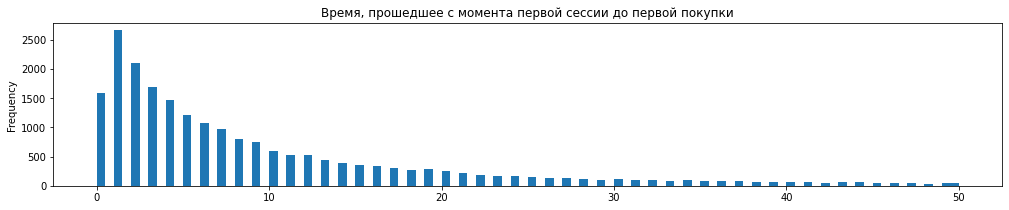

In [31]:
#найдем время, прошедшее с момента первой сессии до первой покупки
first_orders['time_to_first_purchase'] = (first_orders['first_buy_ts'] - first_orders['first_activity']) / np.timedelta64(1, 'm')
first_orders['time_to_first_purchase'].plot(kind = 'hist', bins = 100, range = (0,50), figsize = (17,3), title = 'Время, прошедшее с момента первой сессии до первой покупки')
print('Медиана времени с первой сессии до первой покупки: {} минут'.format(int(first_orders['time_to_first_purchase'].median())))
print('Среднее время с певрой сессии до первой покупки: {} дней'.format(int(first_orders['time_to_first_purchase'].mean()/60/24)))
print('Мода времени с певрой сессии до первой покупки: {} минута'.format(int(first_orders['time_to_first_purchase'].mode())))


#### Сколько раз покупают за период?

In [0]:
#добавим в orders дату первого заказа и выведем в отдельный столбец месяц первого заказа
orders = orders.join(first_orders, on='uid')
orders['first_buy_month'] = orders['first_buy_ts'].astype('datetime64[M]')
orders['first_session_month'] = orders['first_activity'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [33]:
orders['buy_date'] = orders['buy_ts'].dt.date
orders['buy_week'] = orders['buy_ts'].dt.week
orders['buy_year'] = orders['buy_ts'].dt.year
day_purchases_per_user = orders.groupby(['buy_date', 'uid']).agg({'buy_ts':'count'}).mean()[0]
week_purchases_per_user = orders.groupby(['buy_year', 'buy_week', 'uid']).agg({'buy_ts':'count'}).mean()[0]
month_purchases_per_user = orders.groupby(['buy_month', 'uid']).agg({'buy_ts':'count'}).mean()[0]
year_purchases_per_user = orders.groupby(['buy_year', 'uid']).agg({'buy_ts':'count'}).mean()[0]
print('''В среднем на одного пользователя покупок:
В день - {:.2f},
В неделю - {:.2f},
В месяц - {:.2f},
В год - {:.2f}

Покупок мало, сделаем когортный анализ по количеству покупок на человека - когорты выведем по дате первой сессии'''.format(day_purchases_per_user, week_purchases_per_user, month_purchases_per_user, year_purchases_per_user))

В среднем на одного пользователя покупок:
В день - 1.08,
В неделю - 1.16,
В месяц - 1.23,
В год - 1.32

Покупок мало, сделаем когортный анализ по количеству покупок на человека - когорты выведем по дате первой сессии


In [0]:
orders = orders[['uid', 'revenue', 'buy_ts', 'buy_month', 'first_buy_ts', 'first_buy_month', 'first_session_month']]
#посчитаем lifetime заказов
orders['lifetime_fa_b'] = ((orders['buy_month'] - orders['first_session_month']) / np.timedelta64(1, 'M')).round().astype('int')

#сгруппируем заказы по когортам и lifetime и высчитаем кол-во покупок и пользователей
orders_grouped_by_cohorts = orders.groupby(['first_session_month', 'lifetime_fa_b']).agg({'uid':['count', 'nunique']}).reset_index()
orders_grouped_by_cohorts.columns = ['first_session_month', 'lifetime_fa_b', 'n_orders', 'n_users']

#получим количество заказов на одного пользователя по каждой когорте и кадлому lifetime
orders_grouped_by_cohorts['orders_per_user'] = orders_grouped_by_cohorts['n_orders'] / orders_grouped_by_cohorts['n_users']
orders_grouped_by_cohorts['first_session_month'] = orders_grouped_by_cohorts['first_session_month'].dt.strftime('%Y-%m')

#создадим сводную таблицу с когортным анализом количества заказов на пользователя 
cohorts = orders_grouped_by_cohorts.pivot_table(index = 'first_session_month', columns = 'lifetime_fa_b', values = 'orders_per_user', aggfunc = 'mean')
cohorts['mean'] = cohorts.mean(axis=1)

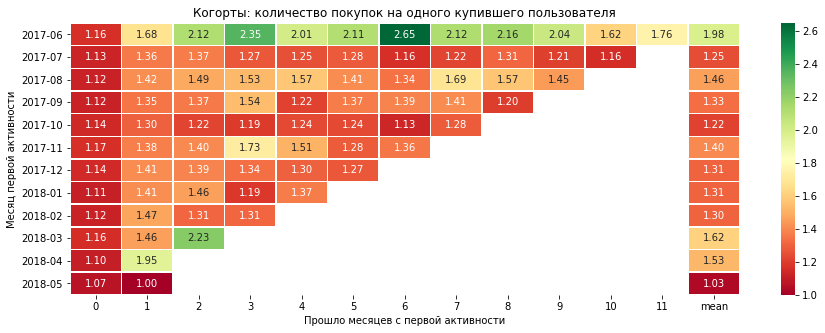

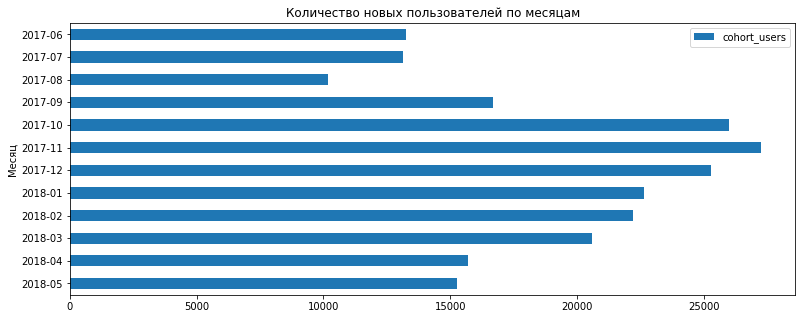

Видим странную картину - именно в тех когортах, где количество новых пользователей самое большое, мы имеем меньшее количество покупок на 1 пользователя
Сделаем когортный анализ и посмотрим сколько пользователей делают покупки по истечению времени, когорты сформируем по времени первой активности, жизнь когорты будем смотреть с первой активности до покупки


In [35]:
plt.figure(figsize=(15, 5))
plt.title('Когорты: количество покупок на одного купившего пользователя')
sns.heatmap(cohorts, annot=True, fmt=".2f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Прошло месяцев с первой активности')
plt.ylabel('Месяц первой активности')
plt.show()
new_users_by_month = new_users_by_month.reset_index()
new_users_by_month = new_users_by_month.sort_values(by= 'first_activity_month', ascending = False)
new_users_by_month = new_users_by_month.set_index('first_activity_month')
new_users_by_month.plot(kind = 'barh', figsize = (13,5), title = 'Количество новых пользователей по месяцам')
plt.ylabel('Месяц')
plt.show()
print('Видим странную картину - именно в тех когортах, где количество новых пользователей самое большое, мы имеем меньшее количество покупок на 1 пользователя'
     '\nСделаем когортный анализ и посмотрим сколько пользователей делают покупки по истечению времени, когорты сформируем по времени первой активности,'
      ' жизнь когорты будем смотреть с первой активности до покупки')

In [0]:
orders['first_session_month'] = orders['first_session_month'].dt.strftime('%Y-%m')

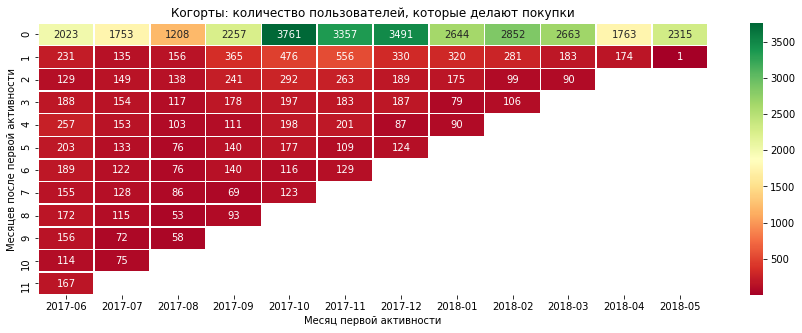

In [37]:
cohorts_buy_n_users = orders.pivot_table(index = 'lifetime_fa_b', columns = 'first_session_month', values = 'uid', aggfunc = 'nunique')
plt.figure(figsize=(15, 5))
plt.title('Когорты: количество пользователей, которые делают покупки')
sns.heatmap(cohorts_buy_n_users, annot=True, fmt=".0f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Месяц первой активности')
plt.ylabel('Месяцев после первой активности')
plt.show()

В месяц в среднем покупок на одного пользователя 1.22
В месяц в среднем ВСЕГО покупок 4201


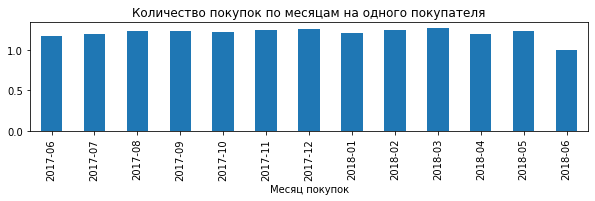

In [38]:
orders_per_user = orders.groupby(['buy_month']).agg({'uid':['count', 'nunique']}).reset_index()
orders_per_user.columns = ['buy_month', 'n_orders', 'n_users']
orders_per_user['orders_per_user'] = orders_per_user['n_orders'] / orders_per_user['n_users']
print('В месяц в среднем покупок на одного пользователя {:.2f}'.format(orders_per_user['orders_per_user'][:-1].mean()))
print('В месяц в среднем ВСЕГО покупок {:.0f}'.format(orders.groupby('buy_month').agg({'uid':'count'})[:-1].mean()[0]))
orders_per_user['buy_month'] = orders_per_user['buy_month'].dt.strftime('%Y-%m')
orders_per_user = orders_per_user.set_index('buy_month')

plt.figure(figsize=(10,2))
orders_per_user['orders_per_user'].plot(kind = 'bar', title = 'Количество покупок по месяцам на одного покупателя')
plt.xlabel('Месяц покупок')
plt.show()


#### Какой средний чек?

Средний чек равен 5.00 $
Далее мы делаем когортный анализ по среднему чеку, НО подразумеваем сумму покупок на одного клиента за период - в нашем случае по месяцам
Почему-то именно так и считался средний чек в курсе, хотя в моем понимании средний чек - это средняя покупка


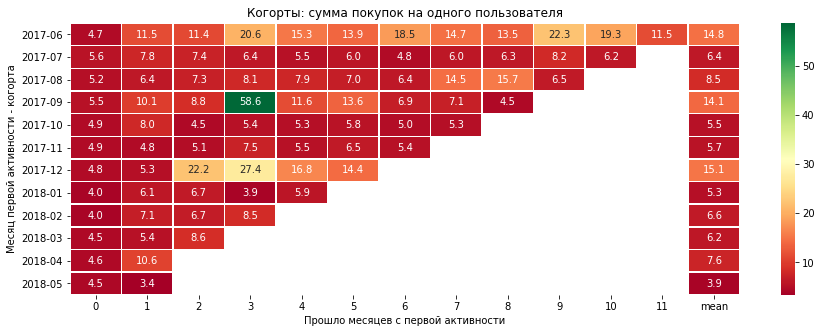

In [39]:
#сгруппируем заказы по когортам и lifetime и суммам покупок на одного пользователя
orders_grouped_by_cohorts = orders.groupby(['first_session_month', 'lifetime_fa_b']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
orders_grouped_by_cohorts.columns = ['first_session_month', 'lifetime_fa_b', 'revenue_total', 'n_users']
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue_total'] / orders_grouped_by_cohorts['n_users']
# orders_grouped_by_cohorts['first_session_month'] = orders_grouped_by_cohorts['first_session_month'].dt.strftime('%Y-%m')

#создадим сводную таблицу с когортным анализом суммы покупок на пользователя 
cohorts_revenue_per_user = orders_grouped_by_cohorts.pivot_table(index = 'first_session_month', columns = 'lifetime_fa_b', values = 'revenue_per_user', aggfunc = 'mean')
cohorts_revenue_per_user['mean'] = cohorts_revenue_per_user.mean(axis=1)

plt.figure(figsize=(15, 5))
plt.title('Когорты: сумма покупок на одного пользователя')
sns.heatmap(cohorts_revenue_per_user, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Прошло месяцев с первой активности')
plt.ylabel('Месяц первой активности - когорта')

print('Средний чек равен {:.2f} $'.format(orders['revenue'].mean()))
print('Далее мы делаем когортный анализ по среднему чеку, НО подразумеваем сумму покупок на одного клиента за период - в нашем случае по месяцам\n'
     'Почему-то именно так и считался средний чек в курсе, хотя в моем понимании средний чек - это средняя покупка')

#### Сколько денег приносят? (LTV)

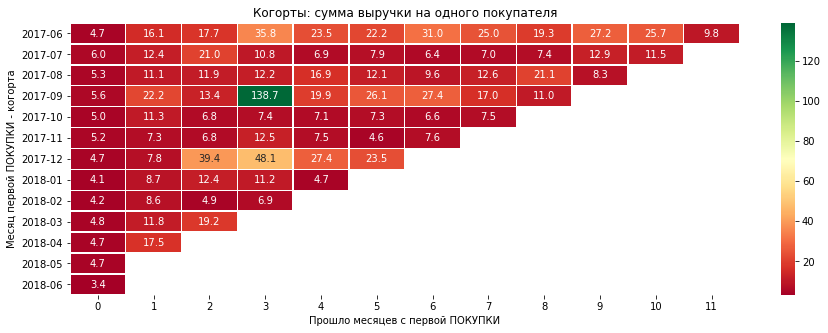

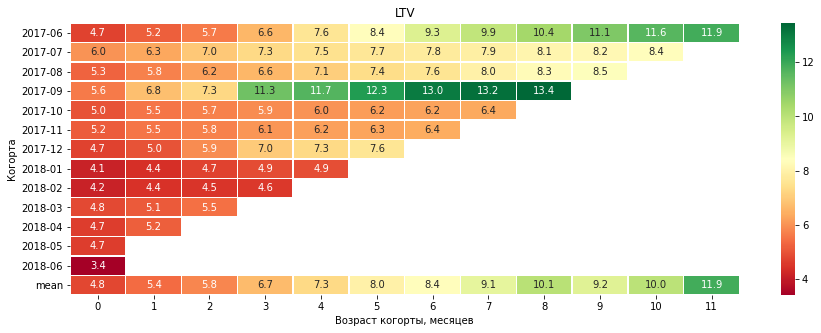

In [40]:
orders['age_cohort'] = ((orders['buy_month'] - orders['first_buy_month']) / np.timedelta64(1, 'M')).round().astype('int')
cohort_sizes_ltv = orders.groupby('first_buy_month').agg({'uid':'nunique'})
cohort_sizes_ltv.columns = ['cohort_size']
orders_grouped_by_cohorts_ltv = orders.groupby(['first_buy_month', 'age_cohort']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.join(cohort_sizes_ltv, on='first_buy_month')
orders_grouped_by_cohorts_ltv['ltv'] = orders_grouped_by_cohorts_ltv['revenue'] / orders_grouped_by_cohorts_ltv['cohort_size']
orders_grouped_by_cohorts_ltv['revenue_per_user'] = orders_grouped_by_cohorts_ltv['revenue'] / orders_grouped_by_cohorts_ltv['uid']

#когортный анализ суммы покупок на одного человека (не LTV)
cohorts_revenue_per_user_2 = orders_grouped_by_cohorts_ltv.pivot_table(
index = 'first_buy_month', columns = 'age_cohort', values = 'revenue_per_user', aggfunc='mean').reset_index()
cohorts_revenue_per_user_2['first_buy_month'] = cohorts_revenue_per_user_2['first_buy_month'].dt.strftime('%Y-%m')
cohorts_revenue_per_user_2 = cohorts_revenue_per_user_2.set_index('first_buy_month')
plt.figure(figsize=(15, 5))
plt.title('Когорты: сумма выручки на одного покупателя')
sns.heatmap(cohorts_revenue_per_user_2, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Прошло месяцев с первой ПОКУПКИ')
plt.ylabel('Месяц первой ПОКУПКИ - когорта')
plt.show()

#когортный анализ LTV
ltv = orders_grouped_by_cohorts_ltv.pivot_table(
index = 'first_buy_month', columns = 'age_cohort', values = 'ltv', aggfunc = 'mean')
ltv = ltv.cumsum(axis = 1)
ltv = ltv.reset_index()
ltv['first_buy_month'] = ltv['first_buy_month'].dt.strftime('%Y-%m')
ltv = ltv.set_index('first_buy_month')
ltv.loc['mean'] = ltv.mean()
ltv = ltv.round(2)
ltv

plt.figure(figsize=(15, 5))
plt.title('LTV')
sns.heatmap(ltv, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Когорта')
plt.show()

### Маркетинг
#### Сколько денег потратили? Всего / на каждый источник / по времени

Всего потрачено на маркетинг 329131.62 $

Всего потрачено на каждый из источников


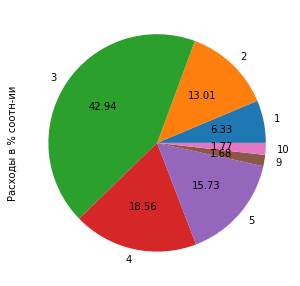

               costs
source_id           
1           20833.27
2           42806.04
3          141321.63
4           61073.60
5           51757.10
9            5517.49
10           5822.49


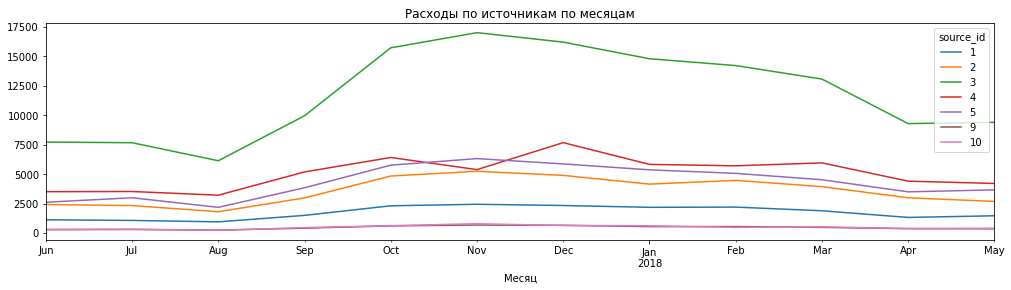

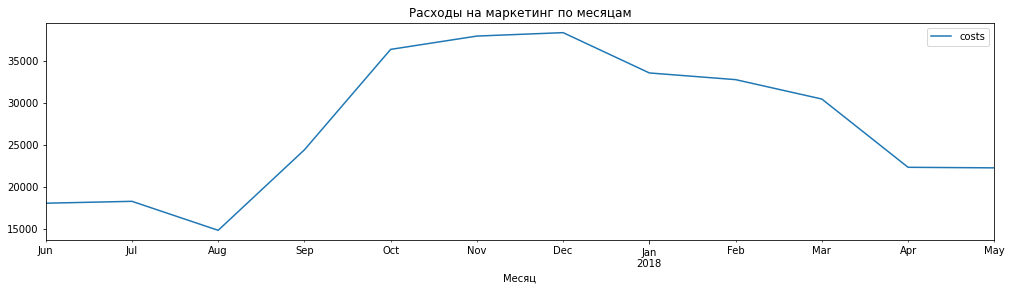

In [41]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
# costs['cost_month'] = costs['cost_month'].dt.strftime('%Y-%m')
print('Всего потрачено на маркетинг {} $'.format(costs['costs'].sum()))
print('\nВсего потрачено на каждый из источников')
costs.groupby('source_id').sum().plot(y = 'costs', autopct='%.2f', kind = 'pie', figsize = (5, 5), legend = False)
plt.ylabel('Расходы в % соотн-ии')
plt.show()
print(costs.groupby('source_id').sum())

costs_pivot = costs.pivot_table(index = 'cost_month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
costs_pivot.plot(figsize = (17,4), title = 'Расходы по источникам по месяцам')
plt.xlabel('Месяц')
plt.show()

costs.pivot_table(index = 'cost_month', values = 'costs', aggfunc = 'sum').plot(title = 'Расходы на маркетинг по месяцам', figsize = (17,4))
plt.xlabel('Месяц')
plt.show()

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [42]:
print('Кол-во пользователей приходивших в сервис по разному кол-ву источников:')
print(visits.groupby('uid').agg({'source_id':'nunique'})['source_id'].value_counts())

visits_sources_none = visits[['uid', 'start_ts', 'end_ts', 'first_activity', 'source_id']]
visits_sources_none = visits_sources_none.join(first_orders[['first_buy_ts']], on='uid')

Кол-во пользователей приходивших в сервис по разному кол-ву источников:
1    190449
2     28642
3      6792
4      1761
5       442
6        74
7         9
Name: source_id, dtype: int64


In [0]:
visits_sources_none

#напишем функцию проверки сессий на факт покупки
def what_session(row):
    if row['start_ts']<=row['first_buy_ts']<=row['end_ts']:
        return True
    else:
        return False

#найдем сессии в которые совершили покупки
visits_sources_none['buy_session'] = visits_sources_none.apply(what_session, axis = 1)

In [0]:
def before_first_purchase(row):
    if row['start_ts'] <= row['first_buy_ts']:
        return True
    else:
        return False
visits_sources_none['before_first_purchase'] = visits_sources_none.apply(before_first_purchase, axis = 1)

In [45]:
visits_before_first_purchase = visits_sources_none[(visits_sources_none['before_first_purchase'] == True)&(visits_sources_none['buy_session'] == False)]
sources_before_first_purchase = visits_before_first_purchase.pivot_table(index = 'uid', columns = 'source_id', values = 'before_first_purchase', aggfunc = 'sum')
sources_before_first_purchase['sessions_before_first_purchase'] = sources_before_first_purchase.sum(axis = 1)

print('Сессий на 1 пользователя перед покупкой: {:.2f}'.format(sources_before_first_purchase['sessions_before_first_purchase'].mean()))
print('Всего сессий на 1 пользователя: {:.2f}'.format(sessions_per_user))
sources_before_first_purchase = sources_before_first_purchase.fillna(0)
sources_before_first_purchase = sources_before_first_purchase.astype('int')

for i in range(1,11):
    try:
        print('Источник source_{} - используется ВПЛОТЬ до первой покупки {:.1%} пользователями'.format(i, sources_before_first_purchase[i].mean()))
    except:
            print('Источник source_{} - используется ВПЛОТЬ до первой покупки 0.0% пользователями'.format(i))

Сессий на 1 пользователя перед покупкой: 1.77
Всего сессий на 1 пользователя: 1.57
Источник source_1 - используется ВПЛОТЬ до первой покупки 23.2% пользователями
Источник source_2 - используется ВПЛОТЬ до первой покупки 28.9% пользователями
Источник source_3 - используется ВПЛОТЬ до первой покупки 39.8% пользователями
Источник source_4 - используется ВПЛОТЬ до первой покупки 44.2% пользователями
Источник source_5 - используется ВПЛОТЬ до первой покупки 26.4% пользователями
Источник source_6 - используется ВПЛОТЬ до первой покупки 0.0% пользователями
Источник source_7 - используется ВПЛОТЬ до первой покупки 0.0% пользователями
Источник source_8 - используется ВПЛОТЬ до первой покупки 0.0% пользователями
Источник source_9 - используется ВПЛОТЬ до первой покупки 8.4% пользователями
Источник source_10 - используется ВПЛОТЬ до первой покупки 5.7% пользователями


In [46]:
visits_purchase = visits_sources_none[visits_sources_none['buy_session'] == True]
sources_first_purchase = visits_purchase.pivot_table(index = 'uid', columns = 'source_id', values = 'before_first_purchase', aggfunc = 'sum')
sources_first_purchase = sources_first_purchase.fillna(0)
sources_first_purchase = sources_first_purchase.astype('int')

for i in range(1,11):
    try:
        print('Источник source_{} - используется ВО ВРЕМЯ ПОКУПКИ {:.1%} пользователями'.format(i, sources_first_purchase[i].mean()))
    except:
            print('Источник source_{} - используется ВО ВРЕМЯ ПОКУПКИ 0.0% пользователями'.format(i))

Источник source_1 - используется ВО ВРЕМЯ ПОКУПКИ 12.4% пользователями
Источник source_2 - используется ВО ВРЕМЯ ПОКУПКИ 10.3% пользователями
Источник source_3 - используется ВО ВРЕМЯ ПОКУПКИ 24.8% пользователями
Источник source_4 - используется ВО ВРЕМЯ ПОКУПКИ 26.4% пользователями
Источник source_5 - используется ВО ВРЕМЯ ПОКУПКИ 20.5% пользователями
Источник source_6 - используется ВО ВРЕМЯ ПОКУПКИ 0.0% пользователями
Источник source_7 - используется ВО ВРЕМЯ ПОКУПКИ 0.0% пользователями
Источник source_8 - используется ВО ВРЕМЯ ПОКУПКИ 0.0% пользователями
Источник source_9 - используется ВО ВРЕМЯ ПОКУПКИ 2.0% пользователями
Источник source_10 - используется ВО ВРЕМЯ ПОКУПКИ 3.6% пользователями


In [47]:
sources_all_visits = visits_sources_none.pivot_table(index = 'uid', columns = 'source_id', values = 'start_ts', aggfunc = 'count')
sources_all_visits = sources_all_visits.fillna(0)
sources_all_visits = sources_all_visits.astype('int')

for i in range(1,11):
    try:
        print('Источник source_{} - используется {:.1%} пользователями'.format(i, sources_all_visits[i].mean()))
    except:
            print('Источник source_{} - используется 0.0% пользователями'.format(i))

Источник source_1 - используется 14.9% пользователями
Источник source_2 - используется 20.8% пользователями
Источник source_3 - используется 37.4% пользователями
Источник source_4 - используется 44.6% пользователями
Источник source_5 - используется 29.2% пользователями
Источник source_6 - используется 0.0% пользователями
Источник source_7 - используется 0.0% пользователями
Источник source_8 - используется 0.0% пользователями
Источник source_9 - используется 5.8% пользователями
Источник source_10 - используется 4.4% пользователями


In [0]:
visits_sources_none['ts_month'] = visits_sources_none['start_ts'].astype('datetime64[M]')
visits_to_first_purchase = visits_sources_none[visits_sources_none['before_first_purchase'] == True]
visits_to_first_purchase_pivot = visits_to_first_purchase.pivot_table(index = 'ts_month', columns = 'source_id', values = 'start_ts', aggfunc = 'count')
visits_to_first_purchase_pivot['visits_to_purchase'] = visits_to_first_purchase_pivot.sum(axis = 1)
visits_to_first_purchase_pivot
for i in range(1,11):
    try:
        visits_to_first_purchase_pivot[i] = visits_to_first_purchase_pivot[i] / visits_to_first_purchase_pivot['visits_to_purchase']
    except:
        0

In [0]:
visits_to_first_purchase_pivot = visits_to_first_purchase_pivot[[1, 2, 3, 4, 5, 9, 10]].round(2).reset_index()
visits_to_first_purchase_pivot['ts_month'] = visits_to_first_purchase_pivot['ts_month'].dt.strftime('%Y-%m')
visits_to_first_purchase_pivot = visits_to_first_purchase_pivot.set_index('ts_month')

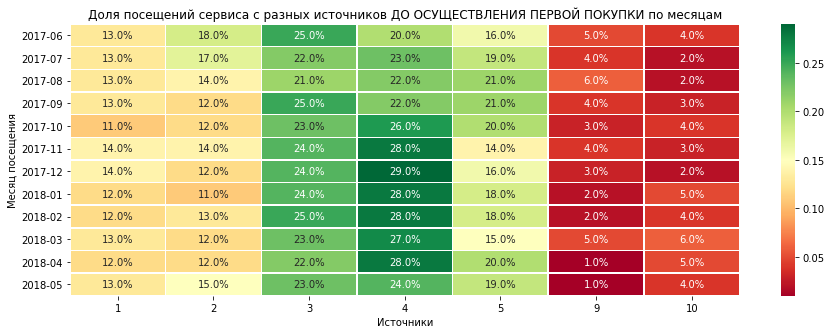

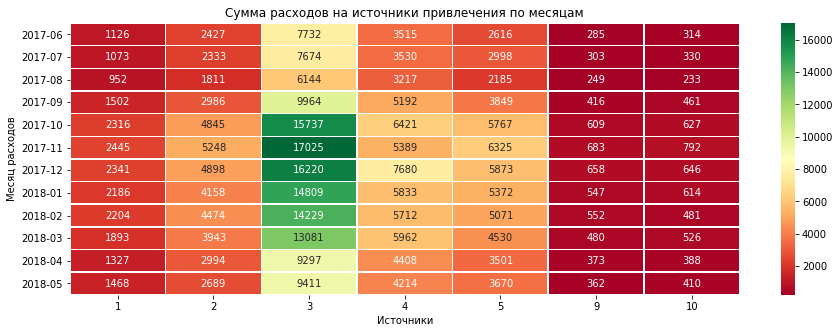

Мы не можем учитывать только источник первого посещения или источник по которому совершили саму покупку
для определения ценности источников, поэтому мы учитываем использование всех источников перехода на сервис,
но в %-ном соотношении, при этом мы не привязываемся к месяцу покупки, так как в нашем расчете мы используем
только те посещения, которые в конечном счете привели к покупке
Можно представить это так:
в месяц 2017-06 - купившие в дальнейшем (может и не в этот месяц) пользователи переходили на сервис именно 
из источника №3 в 25% случаев, конечно же при этом мы понимаем, что до покупки эти пользоватли могли посетить 
сервис не один раз.
Посчитаем стоимость привлечения клиентов из разных источников, учитывая источники ПОКУПКИ (а не первого посещения), а так же посчитаем конверсию по источникам.


In [50]:
plt.figure(figsize=(15, 5))
plt.title('Доля посещений сервиса с разных источников ДО ОСУЩЕСТВЛЕНИЯ ПЕРВОЙ ПОКУПКИ по месяцам')
sns.heatmap(visits_to_first_purchase_pivot, annot=True, fmt=".1%", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Источники')
plt.ylabel('Месяц посещения')
plt.show()

costs_pivot = costs_pivot.reset_index()
costs_pivot['cost_month'] = costs_pivot['cost_month'].dt.strftime('%Y-%m')
costs_pivot = costs_pivot.set_index('cost_month')

plt.figure(figsize=(15, 5))
plt.title('Сумма расходов на источники привлечения по месяцам')
sns.heatmap(costs_pivot, annot=True, fmt=".0f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Источники')
plt.ylabel('Месяц расходов')
plt.show()


print('''Мы не можем учитывать только источник первого посещения или источник по которому совершили саму покупку
для определения ценности источников, поэтому мы учитываем использование всех источников перехода на сервис,
но в %-ном соотношении, при этом мы не привязываемся к месяцу покупки, так как в нашем расчете мы используем
только те посещения, которые в конечном счете привели к покупке
Можно представить это так:
в месяц 2017-06 - купившие в дальнейшем (может и не в этот месяц) пользователи переходили на сервис именно 
из источника №3 в 25% случаев, конечно же при этом мы понимаем, что до покупки эти пользоватли могли посетить 
сервис не один раз.
Посчитаем стоимость привлечения клиентов из разных источников, учитывая источники ПОКУПКИ (а не первого посещения), а так же посчитаем конверсию по источникам.''')

In [0]:
uid_first_source = visits_sources_none.groupby('uid').agg({'buy_session':'sum','start_ts':'min','source_id':'first', 'ts_month':'first'})
sources_count = uid_first_source.pivot_table(index = 'ts_month', columns = 'source_id', values = 'buy_session', aggfunc = ['sum', 'count'])
# visits_sources_none

In [0]:
for i in range(1, 11):
    try:
        sources_count[i] = sources_count['sum'][i] / sources_count['count'][i]
    except:
        np.nan
sources_conversion = sources_count[[1, 2, 3, 4, 5, 9, 10]].reset_index()
sources_conversion['ts_month'] = sources_conversion['ts_month'].dt.strftime('%Y-%m')
sources_conversion = sources_conversion.set_index('ts_month')

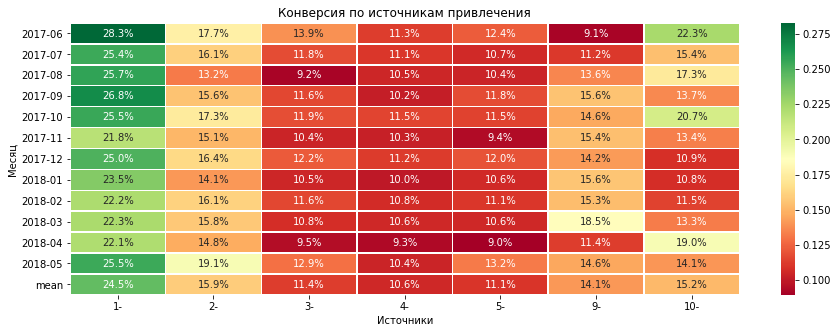

Наиболее эффективен источник 1 - это видно из конверсии, источник №3 отнюдь не самый эффективный,
порекомендуем маркетологам вкладываться в источники с наибольшей конверсией - 1, 2, 9, 10


In [53]:
sources_conversion.loc['mean'] = sources_conversion.mean()

plt.figure(figsize=(15, 5))
plt.title('Конверсия по источникам привлечения')
sns.heatmap(sources_conversion, annot=True, fmt=".1%", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Источники')
plt.ylabel('Месяц')
plt.show()
print('''Наиболее эффективен источник 1 - это видно из конверсии, источник №3 отнюдь не самый эффективный,
порекомендуем маркетологам вкладываться в источники с наибольшей конверсией - 1, 2, 9, 10''')

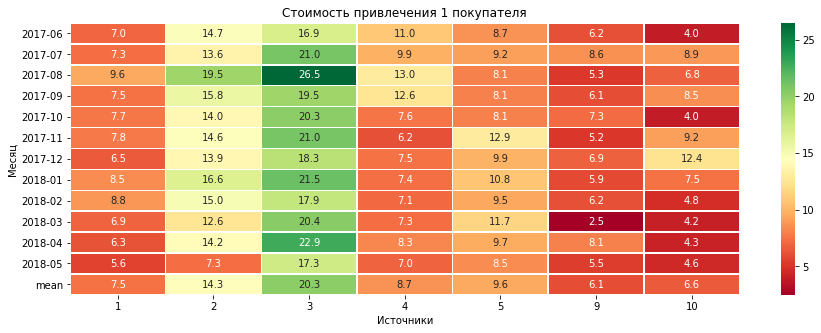

Видим, что любимый маркетологами источник №3 самый дорогой, необходимо 
рассмотреть более дешевые источники привлечения - 1, 9, 10, 2 либо работать над конверсией


In [54]:
number_purchases = uid_first_source.pivot_table(index = 'ts_month', columns = 'source_id', values = 'buy_session', aggfunc = 'sum')
number_purchases = number_purchases[[1, 2, 3, 4, 5, 9, 10]]

cost_one_buyer_by_sources = pd.DataFrame()
for i in range(1,11):
    try:
        cost_one_buyer_by_sources[i] = costs_pivot[i] / number_purchases[i]
    except:
        continue
cost_one_buyer_by_sources.loc['mean'] = cost_one_buyer_by_sources.mean()
cost_one_buyer_by_sources

plt.figure(figsize=(15, 5))
plt.title('Стоимость привлечения 1 покупателя')
sns.heatmap(cost_one_buyer_by_sources, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Источники')
plt.ylabel('Месяц')
plt.show()
print('''Видим, что любимый маркетологами источник №3 самый дорогой, необходимо 
рассмотреть более дешевые источники привлечения - 1, 9, 10, 2 либо работать над конверсией''')

#### На сколько окупились расходы? (ROI)

In [0]:
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.set_index('first_buy_month')

In [0]:
# orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv
costs_by_month = costs.pivot_table(index = 'cost_month', values = 'costs', aggfunc = 'sum').reset_index()
costs_by_month.columns = ['first_buy_month', 'costs']
costs_by_month = costs_by_month.set_index('first_buy_month')

In [0]:
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.join(costs_by_month, on = 'first_buy_month')

In [0]:
orders_grouped_by_cohorts_ltv['cac'] = orders_grouped_by_cohorts_ltv['costs'] / orders_grouped_by_cohorts_ltv['cohort_size']
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv[:-1]
orders_grouped_by_cohorts_ltv['romi'] = orders_grouped_by_cohorts_ltv['ltv'] / orders_grouped_by_cohorts_ltv['cac']
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.reset_index()

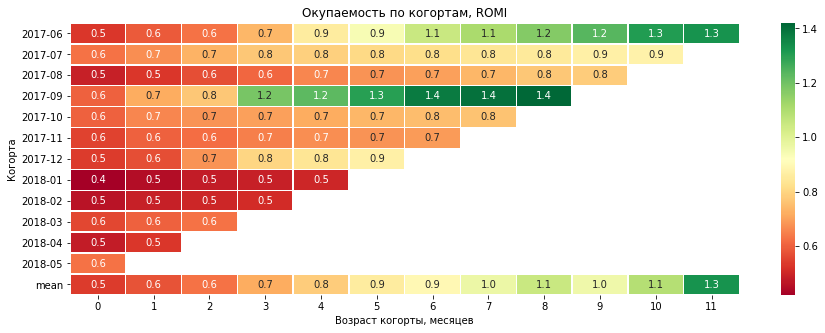

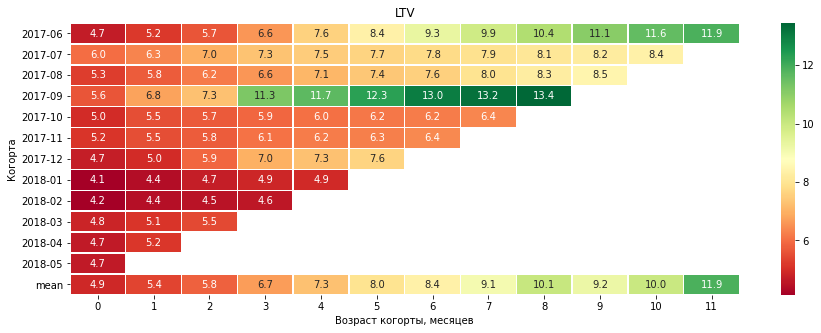

Затраты на маркетинг окупились лишь в когортах 2017-06 (на 6-ой месяц) и 2017-09 (на 3-ий месяц).
Чтобы стоимость привлечения окупалась уже через полгода, необходимо, чтобы стоимость привлечения 1 клиента не была выше 8$
А для этого мы советуем маркетологам обратить внимание на источники привлечения - 1, 9, 10, а также
поработать над конверсией источников, пока лучшая конверсия у источников 1, 2, 9, 10, благодаря чему по ним лучшая стоимость
привлечения 1 клиента.


In [59]:
romi = orders_grouped_by_cohorts_ltv.pivot_table(
index = 'first_buy_month', columns = 'age_cohort', values = 'romi', aggfunc = 'mean')

romi = romi.cumsum(axis=1)
romi = romi.reset_index()
romi['first_buy_month'] = romi['first_buy_month'].dt.strftime('%Y-%m')
romi = romi.set_index('first_buy_month')
romi.loc['mean'] = romi.mean()
romi = romi.round(2)

plt.figure(figsize=(15, 5))
plt.title('Окупаемость по когортам, ROMI')
sns.heatmap(romi, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Когорта')
plt.show()

ltv = orders_grouped_by_cohorts_ltv.pivot_table(
index = 'first_buy_month', columns = 'age_cohort', values = 'ltv', aggfunc = 'mean')
ltv = ltv.cumsum(axis = 1)
ltv = ltv.reset_index()
ltv['first_buy_month'] = ltv['first_buy_month'].dt.strftime('%Y-%m')
ltv = ltv.set_index('first_buy_month')
ltv.loc['mean'] = ltv.mean()
ltv = ltv.round(2)
ltv

plt.figure(figsize=(15, 5))
plt.title('LTV')
sns.heatmap(ltv, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Когорта')
plt.show()

print('''Затраты на маркетинг окупились лишь в когортах 2017-06 (на 6-ой месяц) и 2017-09 (на 3-ий месяц).
Чтобы стоимость привлечения окупалась уже через полгода, необходимо, чтобы стоимость привлечения 1 клиента не была выше 8$
А для этого мы советуем маркетологам обратить внимание на источники привлечения - 1, 9, 10, а также
поработать над конверсией источников, пока лучшая конверсия у источников 1, 2, 9, 10, благодаря чему по ним лучшая стоимость
привлечения 1 клиента.''')

## Куда и сколько маркетологам стоит вкладывать денег? Вывод.

Сервисом пользуются редко, покупки в основном совершаются при первом посещении, причем в течении 1 минуты после захода. 1 минута - это наиболее частое время посещения сервиса пользователями. 
Средний чек 1 покупки - 5\$.

Чтобы экономика сходилась по клиентам уже через полгода, нам необходима стоимость привлечения одного клиента на уровне - 7-8 долларов, не дороже. На данный момент подобную стоимость привлечения 1 клиента имеют источники 1, 4, 9 и 10. На текущий момент стратегией маркетинга было использование в основном источника 3, хотя стоимость привлечения 1 клиента по нему равняется около 20 долларов! Конверсия же по нему составляет всего около 10\%. 

Так же хотелось бы обратить внимание маркетологов на источник 4, у него небольшая стоимость привлечения 1 клиента - в среднем около 9.6, но купившие в дальнейшем пользователи чаще всего хотя бы раз до первой покупки пользуются им - примерно 44\% пользователей, совершивших покупку.

Так же я бы хотел, чтобы маркетологи обратили внимание на поведение когорты 2017-09 - данная когорта сильно выделяется на фоне остальных по наибольшей выручке, отличие в выручке большое и возможно - не случайное, видно, что данная когорта в декабре сильно вырвалась вперед по выручке, причём подобных увеличений со стороны других когорт в декабре не наблюдалось. Возможно, данное поведение когорты является следствием именно особенностей рекламной компании.

В целом, ситуация на данный момент оптимистичная, есть куда расти. При акценте маркетологов на более дешевые источники привлечения, сервис мог уже давно окупиться, но теперь обозначены точки роста и ситуация должна улучшиться.